# Проект: классификация

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [77]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

#### Данные о клиентах банка:

* age (возраст);
* job (сфера занятости);
* marital (семейное положение);
* education (уровень образования);
* default (имеется ли просроченный кредит);
* housing (имеется ли кредит на жильё);
* loan (имеется ли кредит на личные нужды);
* balance (баланс).

#### Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

* contact (тип контакта с клиентом);
* month (месяц, в котором был последний контакт);
* day (день, в который был последний контакт);
* duration (продолжительность контакта в секундах).

#### Прочие признаки:

* campaign (количество контактов с этим клиентом в течение текущей кампании);
* pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* previous (количество контактов до текущей кампании)
* poutcome (результат прошлой маркетинговой кампании).

#### Целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

In [78]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [79]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

### Задание 3

In [80]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
def clean_currency(balance):
    if isinstance(balance, str): 
        symbols = {' ': '', '$': '', ',': '.'}
        for key, value in symbols.items():
            balance = balance.replace(key, value)
        return float(balance)
    return balance

df['balance'] = df['balance'].apply(clean_currency)

round(df['balance'].mean(), 3) 

1529.129

### Задание 4

In [81]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код

df['balance'] = df['balance'].fillna(df['balance'].median())

round(df['balance'].mean(), 3) 

1526.936

### Задание 5

In [82]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
job_mode = df['job'].mode()[0]
education_mode = df['education'].mode()[0]

df['job'] = df['job'].apply(lambda x: job_mode if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: education_mode if x =='unknown' else x)

mask = df[(df['job'] == job_mode) & (df['education'] == education_mode)]

round(mask['balance'].mean(), 3)

1598.883

### Задание 6

In [83]:
# удалите все выбросы для признака balance
# ваш код
def outliers_iqr(data, feature): 
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75), 
    iqr = quartile_3 - quartile_1 
    lower_bound = quartile_1 - (iqr * 1.5) 
    upper_bound = quartile_3 + (iqr * 1.5)
    print(lower_bound, upper_bound) 
    outliers = data[(x<lower_bound) | (x > upper_bound)] 
    cleaned = data[(x>=lower_bound) & (x <= upper_bound)] 
    return outliers, cleaned

outliers, cleaned = outliers_iqr(df, 'balance')
print(f"Number of new ones according to Tukey's method: {outliers.shape[0]}")
print(f'Resulting number of records: {cleaned.shape[0]}')

 

-2241.0 4063.0
Number of new ones according to Tukey's method: 1057
Resulting number of records: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

In [84]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
df = cleaned

df['deposit'].value_counts()

deposit
no     5424
yes    4681
Name: count, dtype: int64

Text(0, 0.5, 'Frequency')

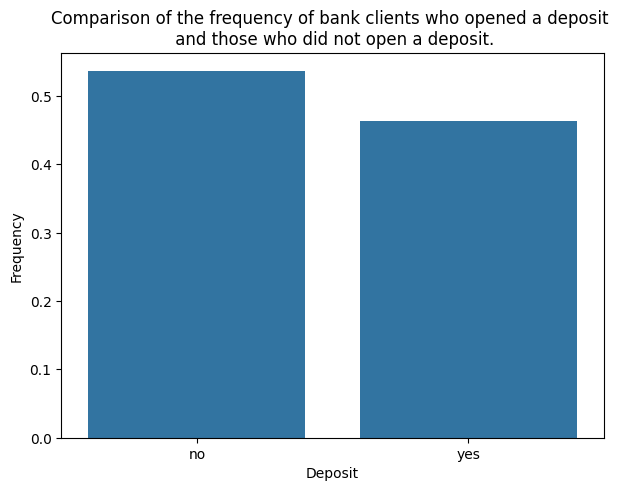

In [85]:
fig, ax = plt.subplots(figsize = (7,5))
sns.barplot(df['deposit'].value_counts(normalize=True))
ax.set_title('Comparison of the frequency of bank clients who opened a deposit \n and those who did not open a deposit.')
ax.set_xlabel('Deposit')
ax.set_ylabel('Frequency')

### Задания 2 и 3

In [86]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


### Задания 4 и 5

In [87]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты
df.describe(include=['object'])

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


### Задание 6

<Axes: xlabel='poutcome'>

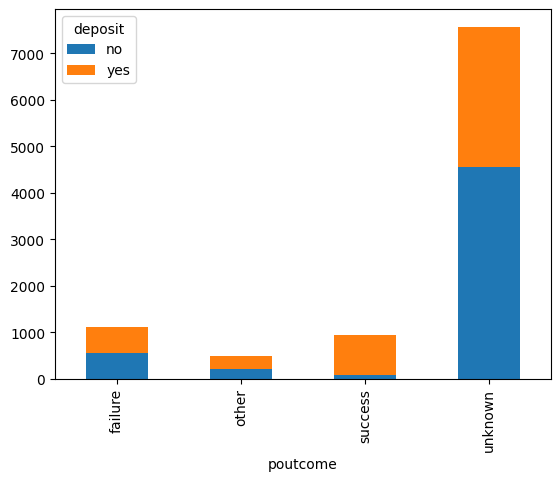

In [88]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
group_poutcome = df.groupby('poutcome')['deposit'].value_counts(normalize=False).unstack()
group_poutcome.plot(kind='bar', stacked='True')

In [89]:
group_poutcome.head()

deposit,no,yes
poutcome,,
failure,562,547
other,216,265
success,84,861
unknown,4562,3008


### Задание 7

In [90]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
for month in np.unique(df['month']):
    no_deposit = df[(df.month == month)&(df.deposit == 'no')].shape[0]
    month_total = df[(df.month == month)].shape[0]
    result = np.round(no_deposit / month_total *100, 2)
    print(f'{month}: {result}%')  

apr: 38.19%
aug: 55.96%
dec: 9.68%
feb: 45.56%
jan: 60.82%
jul: 58.96%
jun: 54.89%
mar: 10.13%
may: 67.86%
nov: 58.46%
oct: 18.51%
sep: 16.55%


### Задание 8

<Axes: xlabel='age_grop', ylabel='count'>

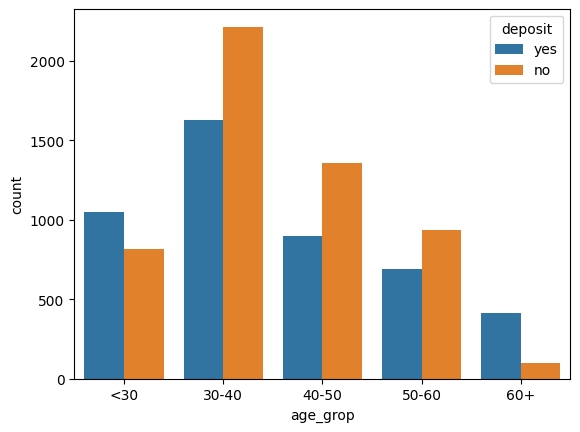

In [91]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
df['age_grop'] = pd.cut(df['age'], [0, 30, 40, 50, 60, 999], labels=['<30', '30-40', '40-50', '50-60','60+'])
sns.countplot(df, x='age_grop', hue='deposit')

### Задания 9 и 10

<Axes: xlabel='marital', ylabel='count'>

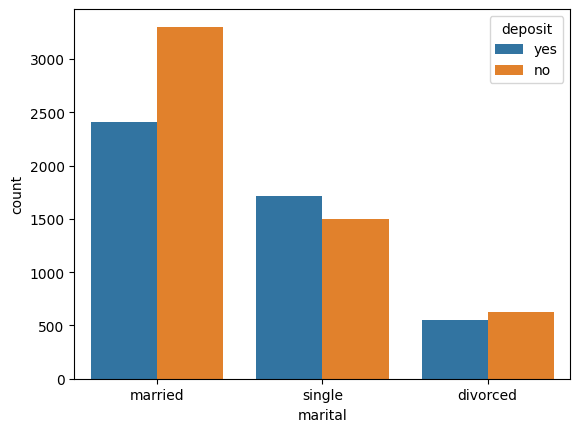

In [92]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
sns.countplot(df, x='marital', hue='deposit') 

<Axes: xlabel='education', ylabel='count'>

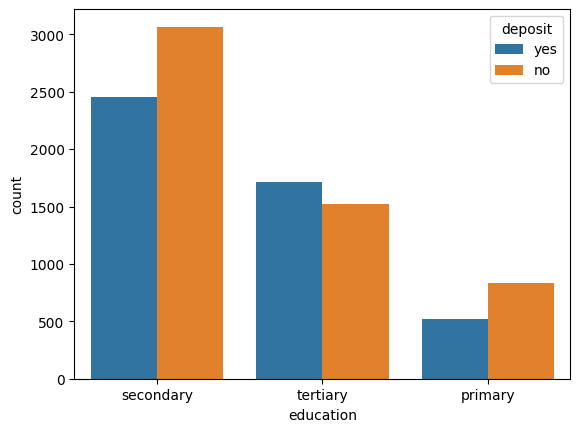

In [93]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
sns.countplot(df, x='education', hue='deposit') 

<Axes: xlabel='job', ylabel='count'>

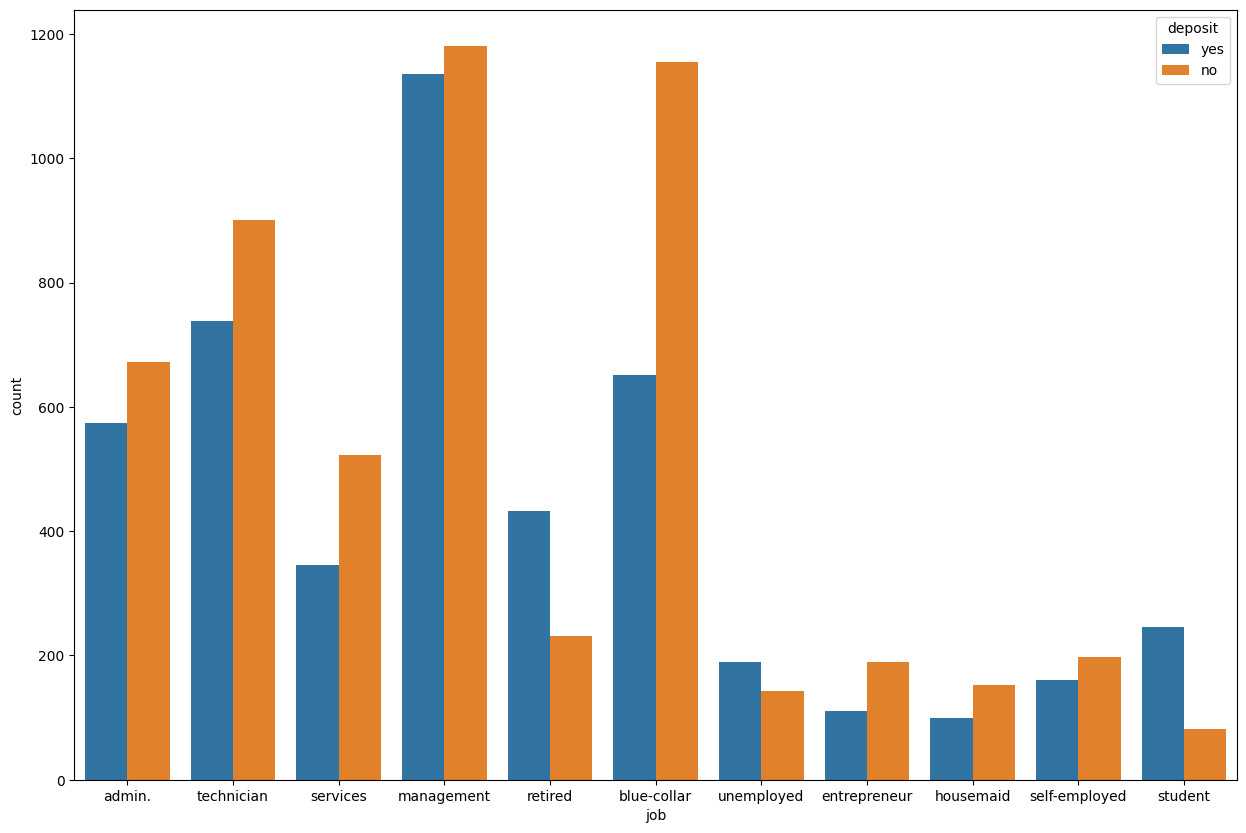

In [94]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
fig, ax = plt.subplots(figsize=(15,10))
sns.countplot(df, x='job', hue='deposit') 

### Задание 11

<Axes: xlabel='education', ylabel='marital'>

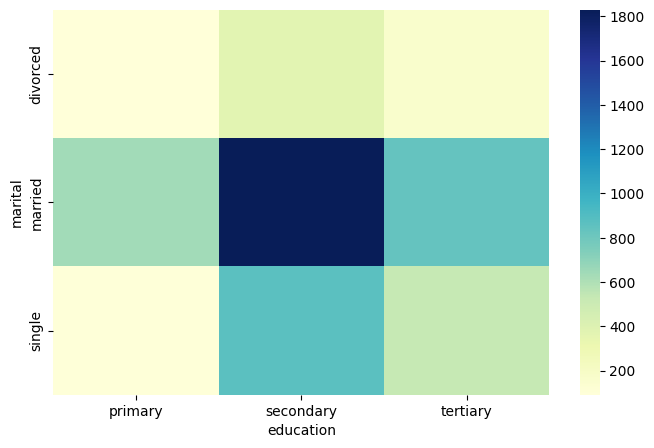

In [95]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
no_deposit_cros = pd.crosstab(df[df['deposit'] == 'no']['marital'], df[df['deposit'] == 'no']['education'])
yes_deposit_cros = pd.crosstab(df[df['deposit'] == 'yes']['marital'], df[df['deposit'] == 'yes']['education'])
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(no_deposit_cros, cmap='YlGnBu')


<Axes: xlabel='education', ylabel='marital'>

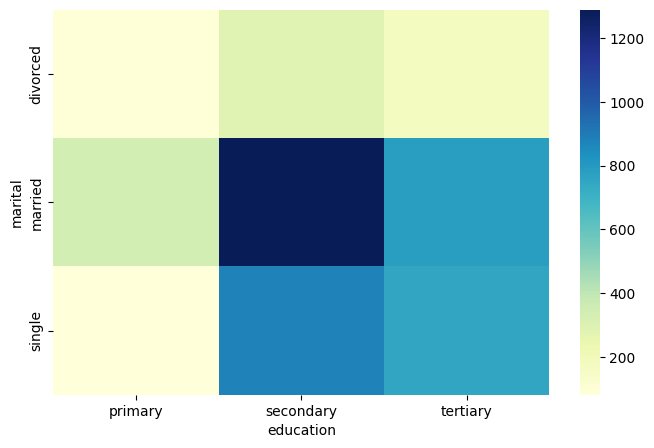

In [96]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(yes_deposit_cros, cmap='YlGnBu')

## Часть 3: преобразование данных

### Задание 1

In [97]:
# преобразуйте уровни образования
encoder = LabelEncoder()
df['education'] = encoder.fit_transform(df['education'])
df['education'].sum()

11995

### Задания 2 и 3

In [98]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df['age_grop'] = encoder.fit_transform(df['age_grop'])
df['deposit'] = encoder.fit_transform(df['deposit'])
print(round(df['deposit'].std(), 3))

0.499


In [99]:
df['default'] = encoder.fit_transform(df['default'])
df['housing'] = encoder.fit_transform(df['housing'])
df['loan'] = encoder.fit_transform(df['loan'])

default_mean = df['default'].mean()
housing_mean = df['housing'].mean()
loan_mean = df['loan'].mean()

print(round(default_mean + housing_mean + loan_mean, 3)) 

0.635


### Задание 4

In [100]:
# создайте дамми-переменные
dumm_columns = ['job', 'marital', 'contact', 'month', 'poutcome']
dumm_df = pd.get_dummies(df[dumm_columns])
df = pd.concat([df, dumm_df], axis=1)
df.shape[1]

51

### Задания 5 и 6

<Axes: >

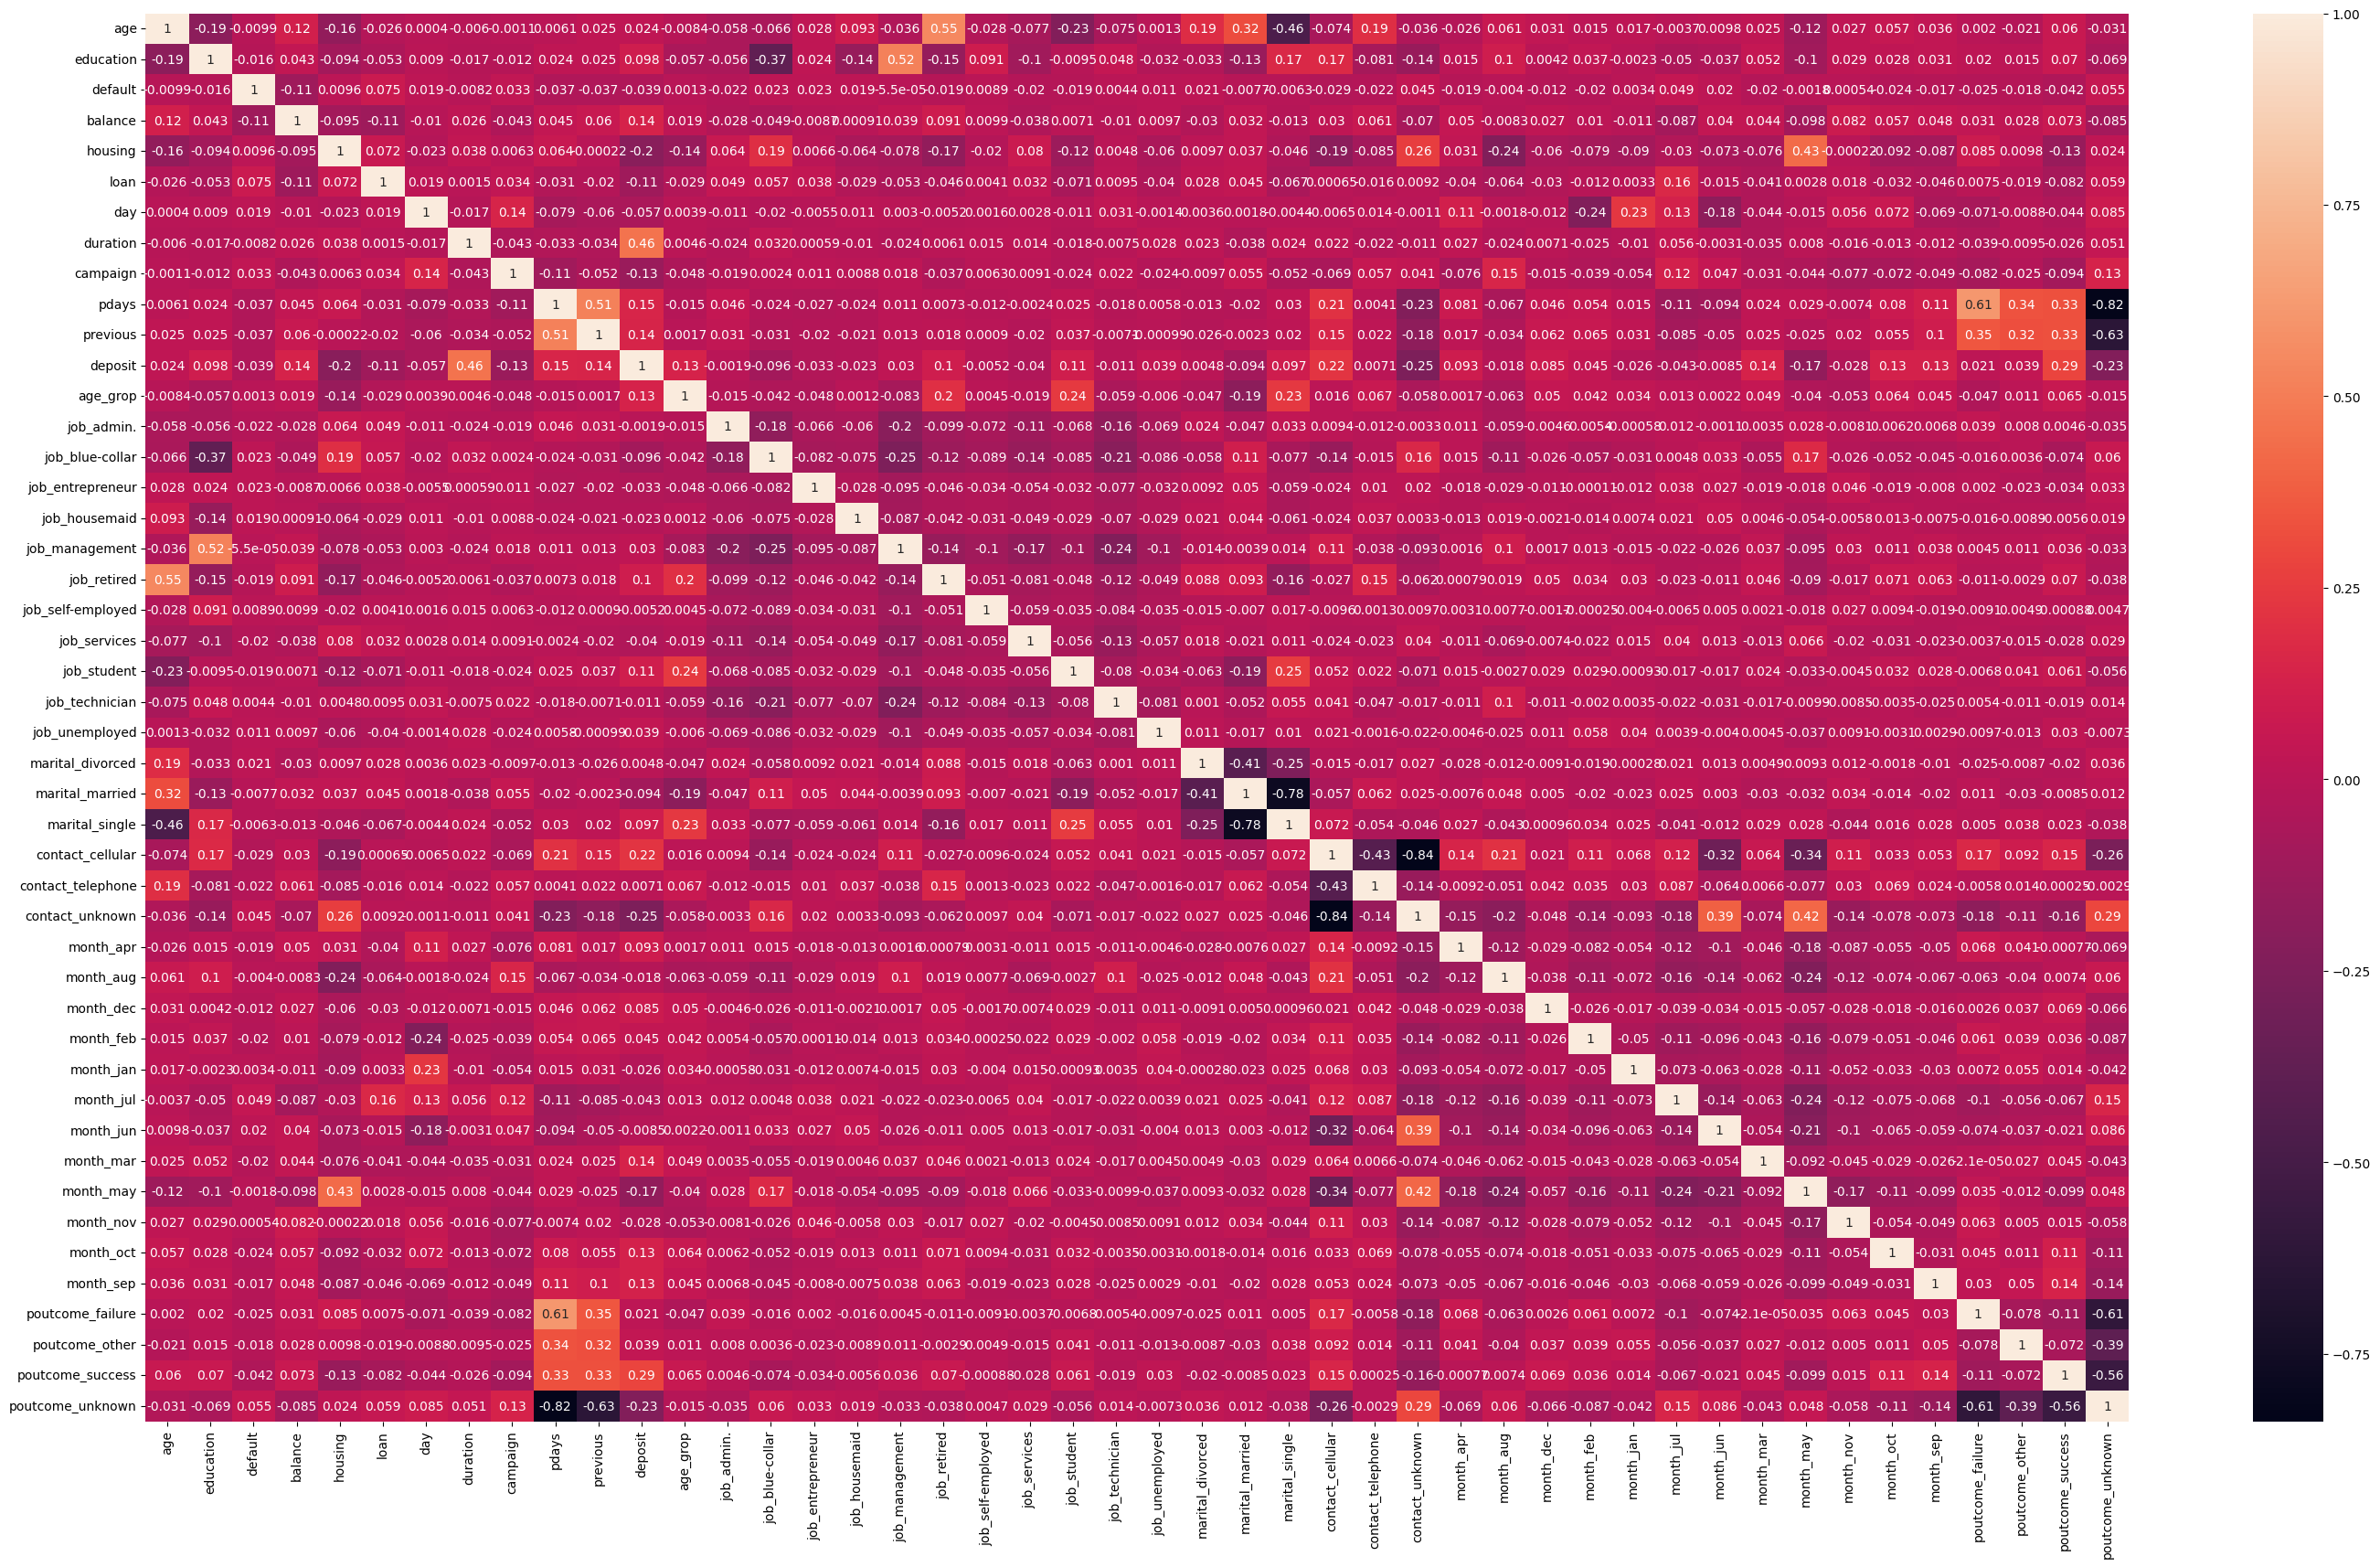

In [101]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
fig, ax = plt.subplots(figsize = (35, 20))
sns.heatmap(df.corr(numeric_only=True), annot=True)

### Задания 7 и 8

In [102]:
X = df.drop(['deposit', 'job', 'marital', 'contact', 'month', 'poutcome'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [103]:
# рассчитайте необходимые показатели
X_test.shape

(3335, 45)

In [104]:
print(np.round(y_test.mean(), 2))

0.46


### Задание 9

In [105]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
selector.get_feature_names_out()

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_grop', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [106]:
df = df[['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_grop', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown','deposit']]

In [107]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

### Задание 10

In [109]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(np.round(X_test_scaled[:, 0].mean(), 2))

0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [112]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_model = linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=1000)
log_model.fit(X_train_scaled, y_train)
print('Accuracy score: {:.2f}'. format(metrics.accuracy_score(y_test, log_model.predict(X_test_scaled))))

Accuracy score: 0.81


### Задания 2,3,4

In [114]:
# обучите решающие деревья, настройте максимальную глубину
dt_model = tree.DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=6)
dt_model.fit(X_train_scaled, y_train)
print(metrics.classification_report(y_test, dt_model.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.85      0.77      0.81      1790
           1       0.76      0.84      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### Задание 5

In [120]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

params = {'min_samples_split': [2, 5, 7, 10], 'max_depth':[3,5,7]}

grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(criterion='entropy', random_state=42),
    param_grid=params,
    cv=3,
    scoring='f1',
    return_train_score=True
)

grid_search.fit(X_train_scaled, y_train)

print(np.round(metrics.f1_score(y_test, grid_search.predict(X_test_scaled)), 2))

0.8


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [123]:
# обучите на ваших данных случайный лес
rf_model = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
rf_model.fit(X_train_scaled, y_train)
print('Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_test, rf_model.predict(X_test_scaled))))
print('Recall score: {:.2f}'.format(metrics.recall_score(y_test, rf_model.predict(X_test_scaled))))

Accuracy score: 0.83
Recall score: 0.83


### Задания 2 и 3

In [125]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
grb_model = ensemble.GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42
)
grb_model.fit(X_train_scaled, y_train)
print('F1 score: {:.2f}'.format(metrics.f1_score(y_test, grb_model.predict(X_test_scaled))))

F1 score: 0.82


### Задание 4

In [128]:
# объедините уже известные вам алгоритмы с помощью стекинга 
estimators = [
    ('li', linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=1000)),
    ('dt', tree.DecisionTreeClassifier(random_state=42, criterion='entropy')),
    ('grd', ensemble.GradientBoostingClassifier(learning_rate = 0.05, n_estimators = 300, min_samples_leaf = 5, max_depth = 5, random_state = 42))
]

stack_model = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)

stack_model.fit(X_train_scaled, y_train)
print('Precision score: {:.2f}'.format(metrics.precision_score(y_test, stack_model.predict(X_test_scaled))))

Precision score: 0.81


### Задание 5

In [136]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
importance = grb_model.feature_importances_
feature_importances_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importance
})

# Сортировка признаков по важности
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)

# Печать признаков и их важности
display(feature_importances_df.head(3))


,feature,importance
2,duration,0.507106
13,poutcome_success,0.114958
8,contact_unknown,0.072582


### Задания 6,7,8

In [147]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score 

In [148]:
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
study.optimize(optuna_rf, n_trials=20)

[I 2024-06-25 18:08:35,569] A new study created in memory with name: RandomForestClassifier
[I 2024-06-25 18:08:36,537] Trial 0 finished with value: 0.8939228245586627 and parameters: {'n_estimators': 176, 'max_depth': 30, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8939228245586627.
[I 2024-06-25 18:08:37,051] Trial 1 finished with value: 0.8528584817244611 and parameters: {'n_estimators': 115, 'max_depth': 22, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8939228245586627.
[I 2024-06-25 18:08:37,620] Trial 2 finished with value: 0.8512900703674746 and parameters: {'n_estimators': 127, 'max_depth': 25, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8939228245586627.
[I 2024-06-25 18:08:38,361] Trial 3 finished with value: 0.8620474406991261 and parameters: {'n_estimators': 157, 'max_depth': 15, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8939228245586627.
[I 2024-06-25 18:08:39,109] Trial 4 finished with value: 0.8556684910086004 and parameters: {'n_

In [149]:
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )
model.fit(X_train_scaled, y_train)

print('F1 train score: {:.2f}'.format(metrics.f1_score(y_test, model.predict(X_test_scaled))))

F1 train score: 0.82


In [150]:
print('Accuracy train score: {:.2f}'.format(metrics.accuracy_score(y_test, model.predict(X_test_scaled))))

Accuracy train score: 0.83
